# Random Forest Implementation

## Set Up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import helpers as hp
import models.randomforest as rf
import models.lstm as lstm


In [2]:
# recent https://forecast.weather.gov/product.php?site=MFL&issuedby=MIA&product=CLI&format=CI&version=2&glossary=0
# Old https://climatecenter.fsu.edu/climate-data-access-tools/downloadable-data


df = pd.read_csv("True values/miami_weather_complete.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [3]:
df = df.drop(columns = {"Unnamed: 0", "precipitation",	"mean temp"})
df

,actual_max_temp,min temp,Datetime
0,81.0,63.0,2000-01-01
1,79.0,66.0,2000-01-02
2,80.0,64.0,2000-01-03
3,80.0,71.0,2000-01-04
4,80.0,67.0,2000-01-05
...,...,...,...
9089,72.0,55.0,2024-11-23
9090,78.0,58.0,2024-11-24
9091,82.0,64.0,2024-11-25
9092,84.0,67.0,2024-11-26


In [4]:
openmeteo = pd.read_csv('Open Meteo forecast/MiamiOpenMeteoData.csv')

In [5]:
openmeteo['time'] = pd.to_datetime(openmeteo['time'], format='%m/%d/%y')

# Convert the datetime column back to the desired string format 'DD/MM/YYYY'
openmeteo['time'] = openmeteo['time'].dt.strftime('%m-%d-%Y')

openmeteo = openmeteo.rename(columns = {"time": "Datetime"})
openmeteo['Datetime'] = pd.to_datetime(openmeteo['Datetime'])
openmeteo.dtypes

Datetime                           datetime64[ns]
weather_code (wmo code)                     int64
temperature_2m_max (°F)                   float64
temperature_2m_min (°F)                   float64
temperature_2m_mean (°F)                  float64
apparent_temperature_max (°F)             float64
apparent_temperature_min (°F)             float64
apparent_temperature_mean (°F)            float64
sunrise (iso8601)                          object
sunset (iso8601)                           object
daylight_duration (s)                     float64
sunshine_duration (s)                     float64
precipitation_sum (mm)                    float64
rain_sum (mm)                             float64
snowfall_sum (cm)                         float64
precipitation_hours (h)                     int64
wind_speed_10m_max (mp/h)                 float64
wind_gusts_10m_max (mp/h)                 float64
wind_direction_10m_dominant (°)           float64
shortwave_radiation_sum (MJ/m²)           float64


In [6]:
newdf = pd.merge(df,openmeteo, how = "inner", on = "Datetime")

In [7]:
newdf = newdf.drop(columns = {'sunrise (iso8601)','sunset (iso8601)', 'weather_code (wmo code)'})

In [8]:
newdf['precipitation_hours (h)'] = newdf['precipitation_hours (h)'].astype(float)
newdf = newdf.set_index("Datetime")

In [9]:
for col in newdf.columns:
            for lag in range(1,7):
                newdf[f'{col}_lag{lag}'] = newdf[col].shift(lag)
newdf = newdf.dropna()
new_lstm_df = newdf.copy()

/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_56992/2430413464.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf[f'{col}_lag{lag}'] = newdf[col].shift(lag)
/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_56992/2430413464.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf[f'{col}_lag{lag}'] = newdf[col].shift(lag)
/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_56992/2430413464.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

## Create training sets

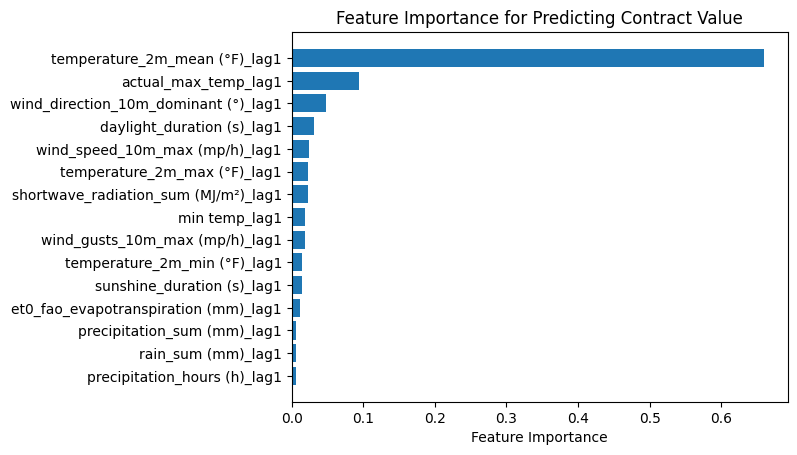

,Feature,Importance
4,temperature_2m_mean (°F)_lag1,0.659662
0,actual_max_temp_lag1,0.094370
12,wind_direction_10m_dominant (°)_lag1,0.048285
5,daylight_duration (s)_lag1,0.030799
10,wind_speed_10m_max (mp/h)_lag1,0.024946
2,temperature_2m_max (°F)_lag1,0.022905
13,shortwave_radiation_sum (MJ/m²)_lag1,0.022236
1,min temp_lag1,0.018528
11,wind_gusts_10m_max (mp/h)_lag1,0.018456
3,temperature_2m_min (°F)_lag1,0.014923


In [12]:
feature_columns = [
        'actual_max_temp_lag1',
       'min temp_lag1', 'temperature_2m_max (°F)_lag1',
       'temperature_2m_min (°F)_lag1', 'temperature_2m_mean (°F)_lag1',
        'daylight_duration (s)_lag1',
       'sunshine_duration (s)_lag1', 'precipitation_sum (mm)_lag1',
       'rain_sum (mm)_lag1', 
       'precipitation_hours (h)_lag1', 'wind_speed_10m_max (mp/h)_lag1',
       'wind_gusts_10m_max (mp/h)_lag1',
       'wind_direction_10m_dominant (°)_lag1',
       'shortwave_radiation_sum (MJ/m²)_lag1',
       'et0_fao_evapotranspiration (mm)_lag1'
]

target = 'actual_max_temp'

rf.find_important_features(newdf, feature_columns, target)

## Testing the performance of the Random Forest model

In [13]:
X = newdf[feature_columns]
y = newdf[target]


X_train, y_train, X_test, y_test = hp.create_train_test(X, y, .8)
all_predictions = pd.DataFrame()

In [ ]:
# grid search
best_model = rf.find_best_random_forest_model(X_train, y_train)

# get predictions
predictions = rf.get_rf_predictions(best_model, X_test)

# Calculate errors
hp.calculate_metrics(y_test, predictions)

Best parameters found:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score:  0.8124198947583373
Mean Squared Error (MSE): 6.8784343536355514
Mean Absolute Error (MAE): 1.9356656950742641
Root Mean Squared Error (RMSE): 2.6226769441994855


(6.8784343536355514, 2.6226769441994855, 1.9356656950742641)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
91/91 - 5s - 52ms/step - accuracy: 0.0000e+00 - loss: 0.5893 - val_accuracy: 0.0000e+00 - val_loss: 0.3624
Epoch 2/50
91/91 - 1s - 10ms/step - accuracy: 0.0000e+00 - loss: 0.3648 - val_accuracy: 0.0000e+00 - val_loss: 0.3033
Epoch 3/50
91/91 - 1s - 10ms/step - accuracy: 0.0000e+00 - loss: 0.3193 - val_accuracy: 0.0000e+00 - val_loss: 0.2729
Epoch 4/50
91/91 - 1s - 10ms/step - accuracy: 0.0000e+00 - loss: 0.2861 - val_accuracy: 0.0000e+00 - val_loss: 0.2572
Epoch 5/50
91/91 - 1s - 10ms/step - accuracy: 0.0000e+00 - loss: 0.2768 - val_accuracy: 0.0000e+00 - val_loss: 0.2453
Epoch 6/50
91/91 - 1s - 10ms/step - accuracy: 0.0000e+00 - loss: 0.2629 - val_accuracy: 0.0000e+00 - val_loss: 0.2413
Epoch 7/50
91/91 - 1s - 10ms/step - accuracy: 0.0000e+00 - loss: 0.2533 - val_accuracy: 0.0000e+00 - val_loss: 0.2329
Epoch 8/50
91/91 - 1s - 10ms/step - accuracy: 0.0000e+00 - loss: 0.2471 - val_accuracy: 0.0000e+00 - val_loss: 0.2328
Epoch 9/50
91/91 - 1s - 10ms/step - accuracy: 0.0000e+00

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 7, 60)          │        11,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 7, 40)          │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 20)             │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,613 (369.59 KB)

 Trainable params: 31,537 (123.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,076 (246.39 KB)

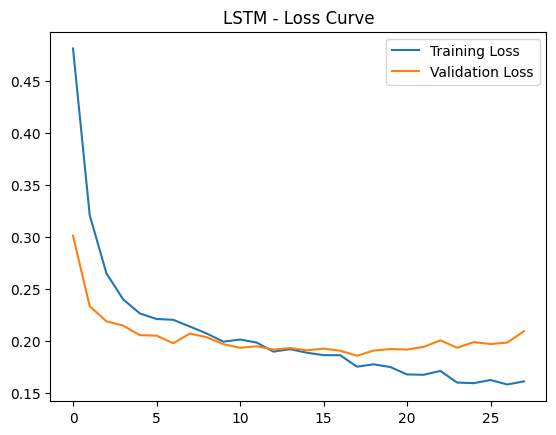

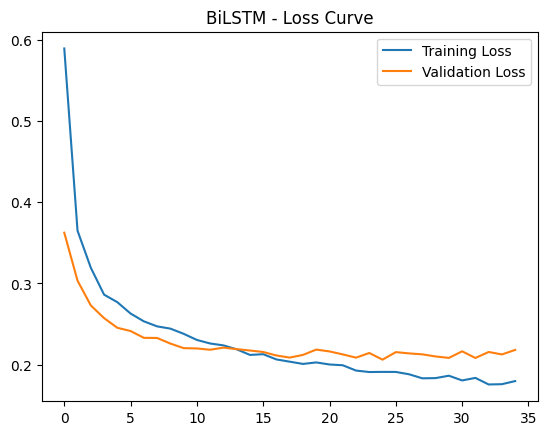

In [14]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, Embedding, LSTM, Bidirectional

# def prepare_data(X_train, y_train, X_test, y_test, window_size=12):
#     feature_scaler = StandardScaler()
#     X_np_train = X_train.values
#     X_scaled_train = feature_scaler.fit_transform(X_np_train)
    
#     target_scaler = StandardScaler()
#     y_np_train = y_train.values
#     y_scaled_train = target_scaler.fit_transform(y_np_train.reshape(-1, 1))
    

y_lstm = new_lstm_df['actual_max_temp']

X_lstm = new_lstm_df[['temperature_2m_mean (°F)_lag1',
 'apparent_temperature_mean (°F)_lag1',
 'apparent_temperature_min (°F)_lag1',
 'apparent_temperature_max (°F)_lag1',
 'actual_max_temp_lag1',
 'wind_direction_10m_dominant (°)_lag1',
 'temperature_2m_max (°F)_lag1']]
 
X_windowed, y_windowed, X_test_windowed, y_test_windowed, feature_scaler, target_scaler = lstm.prepare_data(X_train, y_train, X_test, y_test, window_size=7)

lstm_units = 64  
lstm_batch_size = 64
lstm_epochs = 50
lstm_history, LSTM_model_name, trained_lstm_model = lstm.train_LSTM(X_windowed, y_windowed, lstm_units, lstm_batch_size, lstm_epochs, verbose=2, learning_rate = .0007)

bl_units = 64  
bl_batch_size = 64
bl_epochs = 50
bilstm_history, biLSTM_model_name, trained_bilstm_model = lstm.train_BiLSTM(X_windowed, y_windowed, bl_units, bl_batch_size, bl_epochs, verbose=2, learning_rate = .0005)

# Model summary to check the architecture
trained_bilstm_model.summary()



# Plot loss curves
lstm.plot_loss(lstm_history, LSTM_model_name)
lstm.plot_loss(bilstm_history, biLSTM_model_name)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


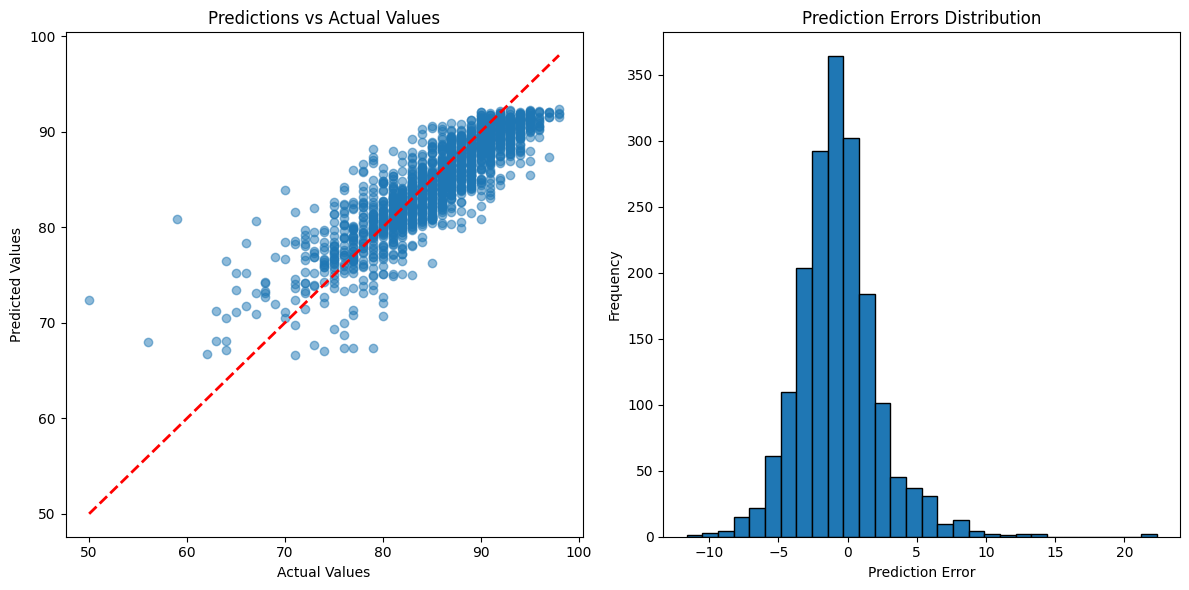

Prediction Error Metrics:
Mean Absolute Error: 2.2423
Mean Squared Error: 9.2469
Root Mean Squared Error: 3.0409


NameError: name 'y_test_original' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
lstm.


bilstm_y_pred = trained_bilstm_model.predict(X_test_windowed)

# Inverse transform predictions and actual values
bilstm_y_pred_original = target_scaler.inverse_transform(bilstm_y_pred)
bilstm_y_test_original = target_scaler.inverse_transform(y_test_windowed)

# Plot predictions vs actual
plt.figure(figsize=(12, 6))

# Scatter plot of predictions vs actual
plt.subplot(1, 2, 1)
plt.scatter(bilstm_y_test_original, bilstm_y_pred_original, alpha=0.5)
plt.plot([bilstm_y_test_original.min(), bilstm_y_test_original.max()], 
         [bilstm_y_test_original.min(), bilstm_y_test_original.max()], 
         'r--', lw=2)
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# # Prediction errors histogram
errors = bilstm_y_pred_original - bilstm_y_test_original
plt.subplot(1, 2, 2)
plt.hist(errors, bins=30, edgecolor='black')
plt.title('Prediction Errors Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate error metrics
mae = np.mean(np.abs(errors))
mse = np.mean(errors**2)
rmse = np.sqrt(mse)

print("Prediction Error Metrics:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


# y_test_original = pd.Series(y_test_original, index=y_lstm_test.index) 
# y_pred_original = pd.Series(y_pred_original, index=y_lstm_test.index) 
plt.figure(figsize=(12, 6))
plt.plot(bilstm_y_test_original, label='Actual', color='blue')
plt.plot(y_pred_original, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

# 1061

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


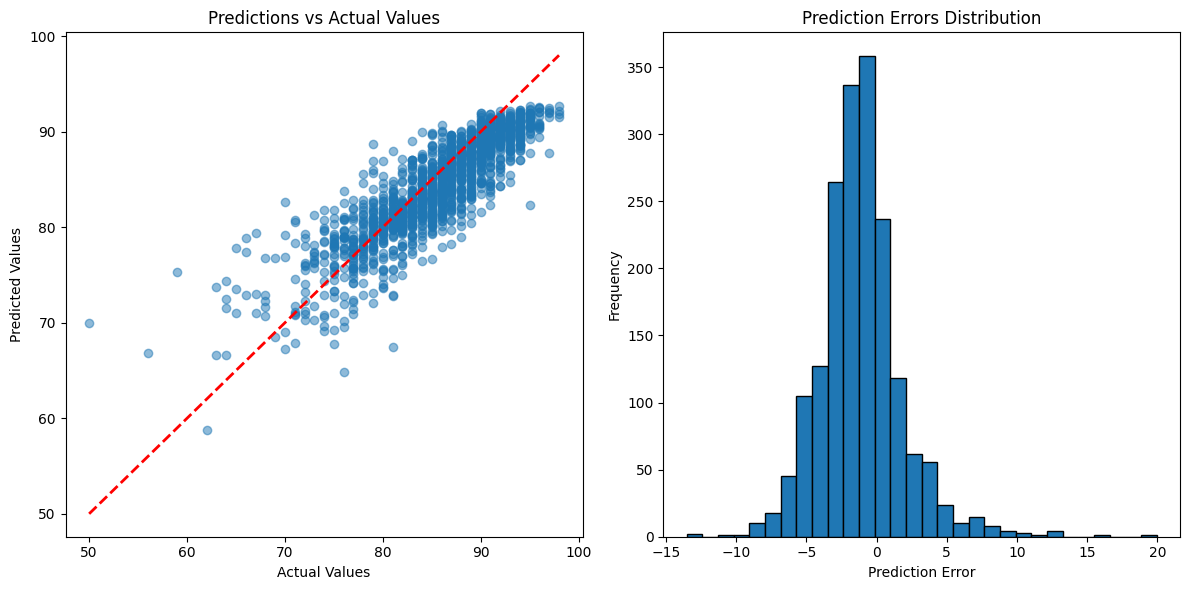

Prediction Error Metrics:
Mean Absolute Error: 2.4106
Mean Squared Error: 10.0429
Root Mean Squared Error: 3.1691


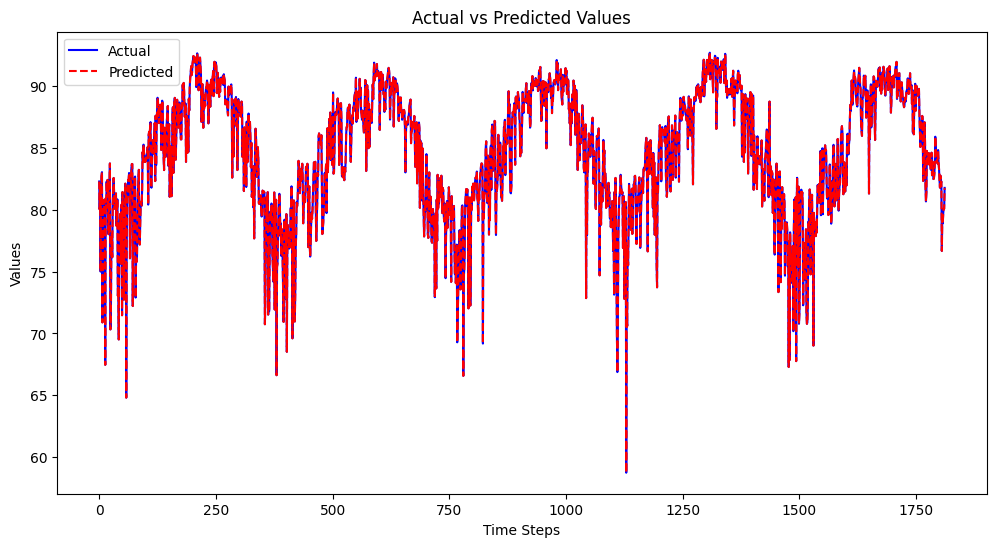

In [19]:
lstm_y_pred = trained_lstm_model.predict(X_test_windowed)

# # Inverse transform predictions and actual values
lstm_y_pred_original = target_scaler.inverse_transform(lstm_y_pred)
lstm_y_test_original = target_scaler.inverse_transform(y_test_windowed)

# Plot predictions vs actual
plt.figure(figsize=(12, 6))

# # Scatter plot of predictions vs actual
plt.subplot(1, 2, 1)
plt.scatter(lstm_y_test_original, lstm_y_pred_original, alpha=0.5)
plt.plot([lstm_y_test_original.min(), lstm_y_test_original.max()], 
         [lstm_y_test_original.min(), lstm_y_test_original.max()], 
         'r--', lw=2)
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# # Prediction errors histogram
errors = lstm_y_pred_original - lstm_y_test_original
plt.subplot(1, 2, 2)
plt.hist(errors, bins=30, edgecolor='black')
plt.title('Prediction Errors Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate error metrics
mae = np.mean(np.abs(errors))
mse = np.mean(errors**2)
rmse = np.sqrt(mse)

print("Prediction Error Metrics:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


# y_test_original = pd.Series(y_test_original, index=y_lstm_test.index) 
# y_pred_original = pd.Series(y_pred_original, index=y_lstm_test.index) 
plt.figure(figsize=(12, 6))
plt.plot(lstm_y_pred_original , label='Actual', color='blue')
plt.plot(lstm_y_pred_original, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

# 1061

In [ ]:
y_actual_test = y_lstm_test.iloc[2:]
rf_predictions = predictions[2:]
predictions_df = pd.DataFrame(y_actual_test)
predictions_df['lstm_predictions'] = lstm_y_pred_original
predictions_df['bilstm_predictions'] = bilstm_y_pred_original
predictions_df['rf_predictions'] = rf_predictions

open_meteo_forecast = pd.read_csv("/Users/bram/Desktop/AI-class/semester-project-bram-long/open-meteo-25.79N80.28W2m.csv")
open_meteo_forecast ['time'] = pd.to_datetime(open_meteo_forecast ['time'], format='%m/%d/%y')
open_meteo_forecast = open_meteo_forecast.set_index("time")


prediction_merge = pd.merge(open_meteo_forecast, predictions_df, left_index=True, right_index=True)
prediction_merge





ValueError: Length of values (210) does not match length of index (104)

In [ ]:

actual = prediction_merge['actual_max_temp']
predicted = prediction_merge['open_meteo_forecast']

# Calculate MSE (Mean Squared Error)
mse = mean_squared_error(actual, predicted)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(actual, predicted)

# Print the results
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

MSE: 4.502521246458923
RMSE: 2.121914523834295
MAE: 1.7540132200188858


In [ ]:
prediction_merge.isna().sum()

open_meteo_forecast    0
actual_max_temp        0
lstm_predictions       0
bilstm_predictions     0
rf_predictions         0
dtype: int64

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 - 7s - 610ms/step - accuracy: 0.0000e+00 - loss: 0.9164 - val_accuracy: 0.0000e+00 - val_loss: 1.1850
Epoch 2/50
11/11 - 0s - 13ms/step - accuracy: 0.0000e+00 - loss: 0.8690 - val_accuracy: 0.0000e+00 - val_loss: 1.1021
Epoch 3/50
11/11 - 0s - 12ms/step - accuracy: 0.0000e+00 - loss: 0.7952 - val_accuracy: 0.0000e+00 - val_loss: 0.9719
Epoch 4/50
11/11 - 0s - 13ms/step - accuracy: 0.0000e+00 - loss: 0.7009 - val_accuracy: 0.0000e+00 - val_loss: 0.7913
Epoch 5/50
11/11 - 0s - 14ms/step - accuracy: 0.0000e+00 - loss: 0.5603 - val_accuracy: 0.0000e+00 - val_loss: 0.5870
Epoch 6/50
11/11 - 0s - 10ms/step - accuracy: 0.0000e+00 - loss: 0.4365 - val_accuracy: 0.0000e+00 - val_loss: 0.4159
Epoch 7/50
11/11 - 0s - 8ms/step - accuracy: 0.0000e+00 - loss: 0.3075 - val_accuracy: 0.0000e+00 - val_loss: 0.3452
Epoch 8/50
11/11 - 0s - 9ms/step - accuracy: 0.0000e+00 - loss: 0.2916 - val_accuracy: 0.0000e+00 - val_loss: 0.3056
Epoch 9/50
11/11 - 0s - 12ms/step - accuracy: 0.0000e+00 

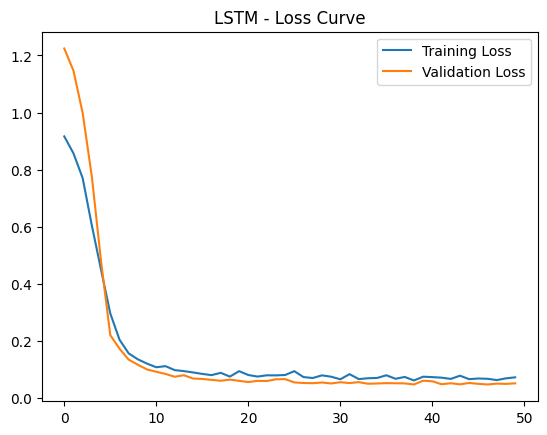

Number of elements in y_train_scaled: 50890


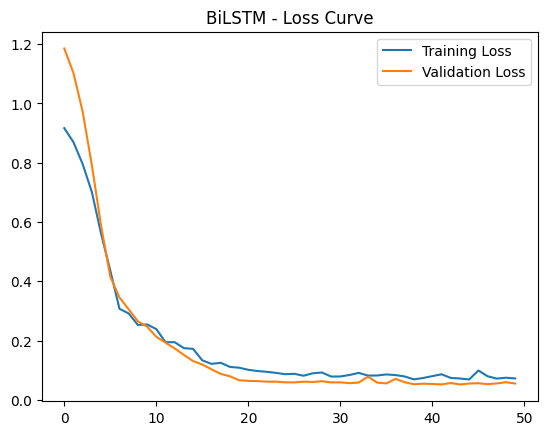

Number of elements in y_train_scaled: 50890


In [ ]:
from sklearn.model_selection import train_test_split

y_new_lstm = prediction_merge['actual_max_temp']

X_new_lstm = prediction_merge[['open_meteo_forecast', 'lstm_predictions',
       'bilstm_predictions', 'rf_predictions']]
 
X_lstm_train, X_temp, y_lstm_train, y_temp = train_test_split(
    X_new_lstm, y_new_lstm, test_size=0.2, random_state=42
)

X_windowed, y_windowed, X_test_windowed, y_test_windowed, feature_scaler, target_scaler = prepare_data(X_lstm_train, y_lstm_train, X_lstm_test,  y_lstm_test, window_size=3)

lstm_units = 64  
lstm_batch_size = 64
lstm_epochs = 50
lstm_history, LSTM_model_name, trained_lstm_model = Train_LSTM(X_windowed, y_windowed, lstm_units, lstm_batch_size, lstm_epochs, verbose=2, learning_rate = .0007)

bl_units = 64  
bl_batch_size = 64
bl_epochs = 50
bilstm_history, ensemble_biLSTM_model_name, ensembtrained_bilstm_model = Train_BiLSTM(X_windowed, y_windowed, bl_units, bl_batch_size, bl_epochs, verbose=2, learning_rate = .0005)



# Plot loss curves
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'{LSTM_model_name} - Loss Curve')
plt.show()
print('Number of elements in y_train_scaled:', len(y_train_scaled))



plt.plot(bilstm_history.history['loss'], label='Training Loss')
plt.plot(bilstm_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'{biLSTM_model_name} - Loss Curve')
plt.show()
print('Number of elements in y_train_scaled:', len(y_train_scaled))




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


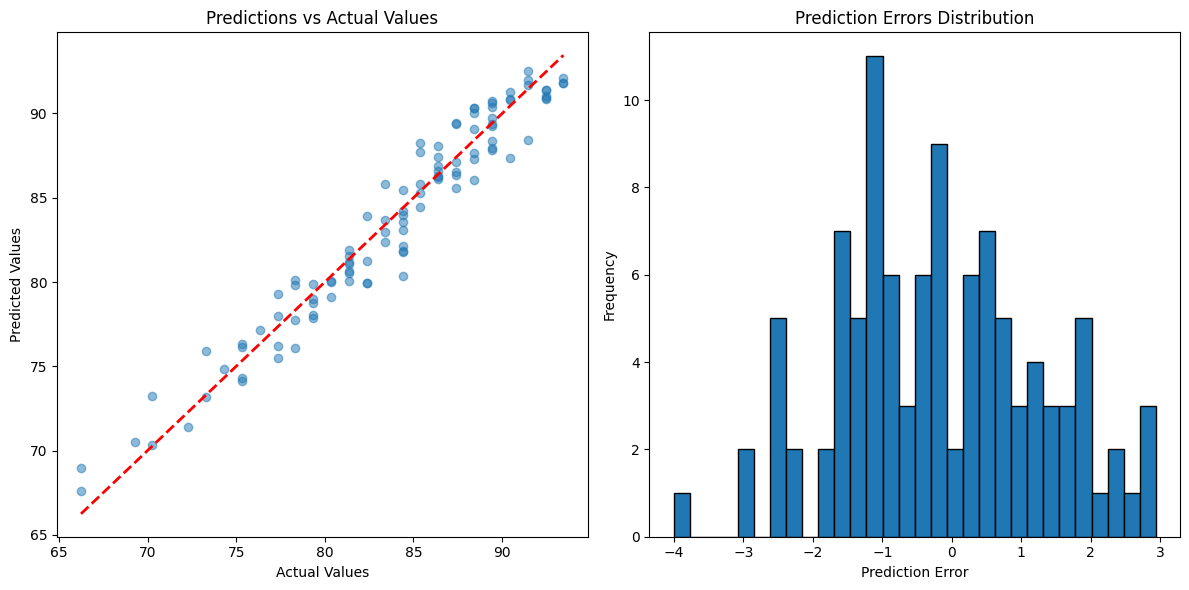

Prediction Error Metrics:
Mean Absolute Error: 1.1925
Mean Squared Error: 2.1140
Root Mean Squared Error: 1.4540


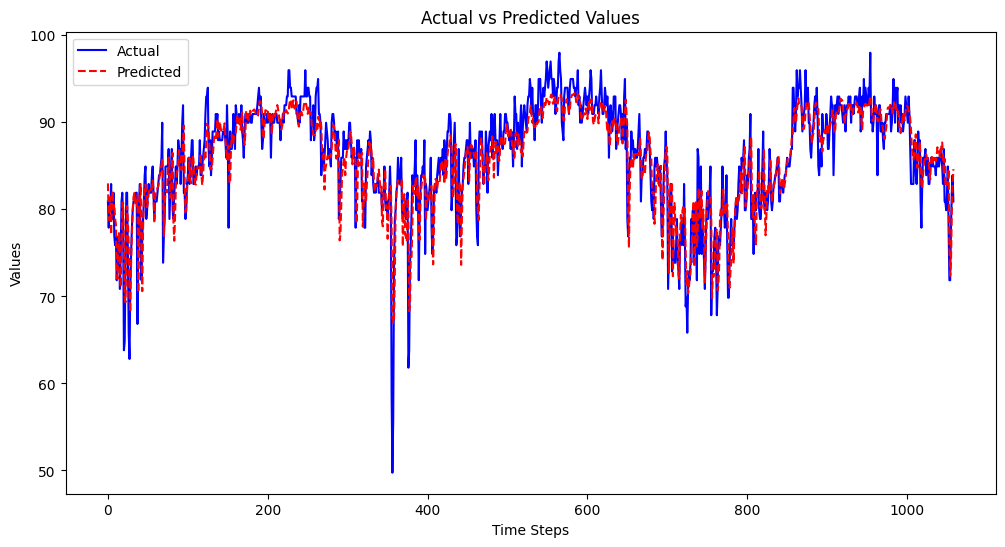

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM Test MAE: 0.1864310064095731
BiLSTM Test MAE: 0.1911524442637448
LSTM Test RMSE: 0.2273078641841987
BiLSTM Test RMSE: 0.23782367111114638
LSTM Test MSE: 0.05166886511998213
BiLSTM Test MSE: 0.05656009854078273


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_reg

In [ ]:
lstm_y_pred = trained_lstm_model.predict(X_test_windowed)

# # Inverse transform predictions and actual values
lstm_y_pred_original = y_scaler.inverse_transform(lstm_y_pred)
lstm_y_test_original = y_scaler.inverse_transform(y_test_windowed)

# Plot predictions vs actual
plt.figure(figsize=(12, 6))

# # Scatter plot of predictions vs actual
plt.subplot(1, 2, 1)
plt.scatter(lstm_y_test_original, lstm_y_pred_original, alpha=0.5)
plt.plot([lstm_y_test_original.min(), lstm_y_test_original.max()], 
         [lstm_y_test_original.min(), lstm_y_test_original.max()], 
         'r--', lw=2)
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# # Prediction errors histogram
errors = lstm_y_pred_original - lstm_y_test_original
plt.subplot(1, 2, 2)
plt.hist(errors, bins=30, edgecolor='black')
plt.title('Prediction Errors Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate error metrics
mae = np.mean(np.abs(errors))
mse = np.mean(errors**2)
rmse = np.sqrt(mse)

print("Prediction Error Metrics:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


# y_test_original = pd.Series(y_test_original, index=y_lstm_test.index) 
# y_pred_original = pd.Series(y_pred_original, index=y_lstm_test.index) 
plt.figure(figsize=(12, 6))
plt.plot( y_test_original, label='Actual', color='blue')
plt.plot(y_pred_original, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()



y_pred_lstm = trained_lstm_model.predict(X_test_windowed)
y_pred_bilstm = ensembtrained_bilstm_model.predict(X_test_windowed)

print("LSTM Test MAE:", mean_absolute_error(y_test_windowed, y_pred_lstm))
print("BiLSTM Test MAE:", mean_absolute_error(y_test_windowed, y_pred_bilstm))
print("LSTM Test RMSE:", mean_squared_error(y_test_windowed, y_pred_lstm, squared=False))
print("BiLSTM Test RMSE:", mean_squared_error(y_test_windowed, y_pred_bilstm, squared=False))
print("LSTM Test MSE:", mean_squared_error(y_test_windowed, y_pred_lstm, squared=True))
print("BiLSTM Test MSE:", mean_squared_error(y_test_windowed, y_pred_bilstm, squared=True))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


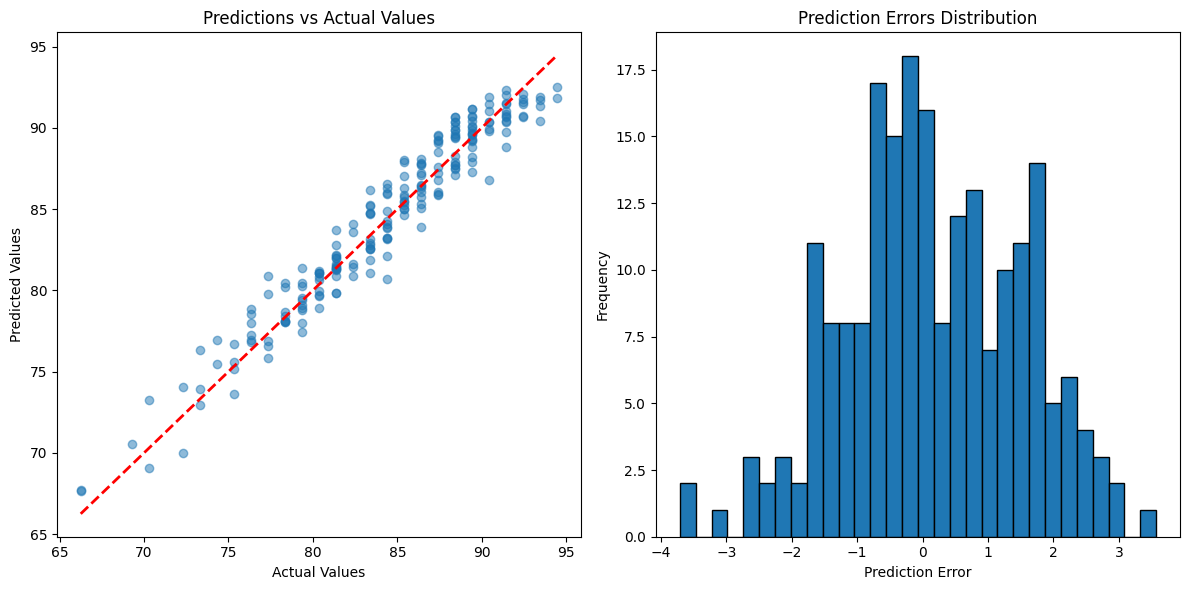

Prediction Error Metrics:
Mean Absolute Error: 1.1017
Mean Squared Error: 1.8579
Root Mean Squared Error: 1.3630


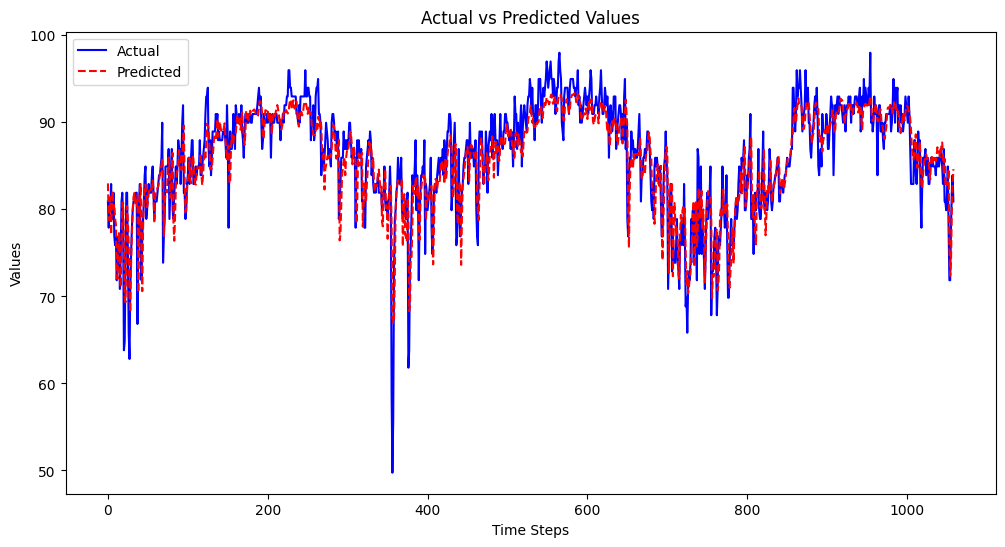

In [ ]:
bilstm_y_pred = trained_bilstm_model.predict(X_test_windowed)

# # Inverse transform predictions and actual values
bilstm_y_pred_original = y_scaler.inverse_transform(bilstm_y_pred)
bilstm_y_test_original = y_scaler.inverse_transform(y_test_windowed)

# Plot predictions vs actual
plt.figure(figsize=(12, 6))

# # Scatter plot of predictions vs actual
plt.subplot(1, 2, 1)
plt.scatter(bilstm_y_test_original, bilstm_y_pred_original, alpha=0.5)
plt.plot([bilstm_y_test_original.min(), bilstm_y_test_original.max()], 
         [bilstm_y_test_original.min(), bilstm_y_test_original.max()], 
         'r--', lw=2)
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# # Prediction errors histogram
errors = bilstm_y_pred_original - bilstm_y_test_original
plt.subplot(1, 2, 2)
plt.hist(errors, bins=30, edgecolor='black')
plt.title('Prediction Errors Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate error metrics
mae = np.mean(np.abs(errors))
mse = np.mean(errors**2)
rmse = np.sqrt(mse)

print("Prediction Error Metrics:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


# y_test_original = pd.Series(y_test_original, index=y_lstm_test.index) 
# y_pred_original = pd.Series(y_pred_original, index=y_lstm_test.index) 
plt.figure(figsize=(12, 6))
plt.plot( y_test_original, label='Actual', color='blue')
plt.plot(y_pred_original, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

# 1061

In [ ]:
print(hp.calculate_metrics(prediction_merge['actual_max_temp'], prediction_merge['open_meteo_forecast'], .8))





(2.1660849056603753, 1.4717625167330413, 1.1872641509433954)


In [ ]:
prediction_merge.columns

Index(['open_meteo_forecast', 'actual_max_temp', 'lstm_predictions',
       'bilstm_predictions', 'rf_predictions'],
      dtype='object')